# A/B Testing

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings 

warnings.filterwarnings('ignore')
sns.set()

An **A/B testing** is: 
- an experiment designed to test which online version is better
- based on metric(s) like signup rate, average sales per user, etc.
- using random assignment and analyzing the results

# When to A/B test and when not to

A/B testing is ok for: 
- optimizing conversion rates
- releasing new app features
- evaluating incremental effects on ads
- assessing the impact of drug trials
- ...

But we should not A/B test if:
- There is no sufficient sample size
- no clear hypothesis to be tested
- ethical considerations
- high opportunity cost

# A/B Testing fundatamental steps 

1. Specify the goal and designs/experiences
2. Randomly sample users for enrollment
3. Randomly assign users to:
    - control variant (current state)
    - treatment/test variant(s): new design
4. Log user actions and compute metrics
5. Test for statistically significant differences to make our decission

Randomization is key to the success of the process
Thanks to randomization, the only difference between the elements of the two groups is the one we introduced. This will allow us to afirm that if there is a estatistically significant difference between those groups it comes from the treatment and not other variables.

In [ ]:
checkout = pd.read_csv('../data/checkout.csv', index_col=0)
checkout.head()

In [ ]:
checkout.info()

In [ ]:
checkout['gender'].value_counts(normalize=True)

In [ ]:
sample_df=checkout.sample(n=3000)

In [ ]:
sample_df['gender'].value_counts(normalize=True)

In [ ]:
checkout.groupby('checkout_page')['gender'].value_counts(normalize=True)

In [ ]:
sample_df.groupby('checkout_page')['gender'].value_counts(normalize=True)

The proportions are manteined after taking a random sample.

# Why running experiments?

- Reduce uncertainty around the impact of new designs and features
- Decision-making -> scientific, evidence-based - not intuition
- Generous value for the investment: simple changes lead to major wins
- Continuous optimization at the mature stage of the business
- Correlation does not imply causation

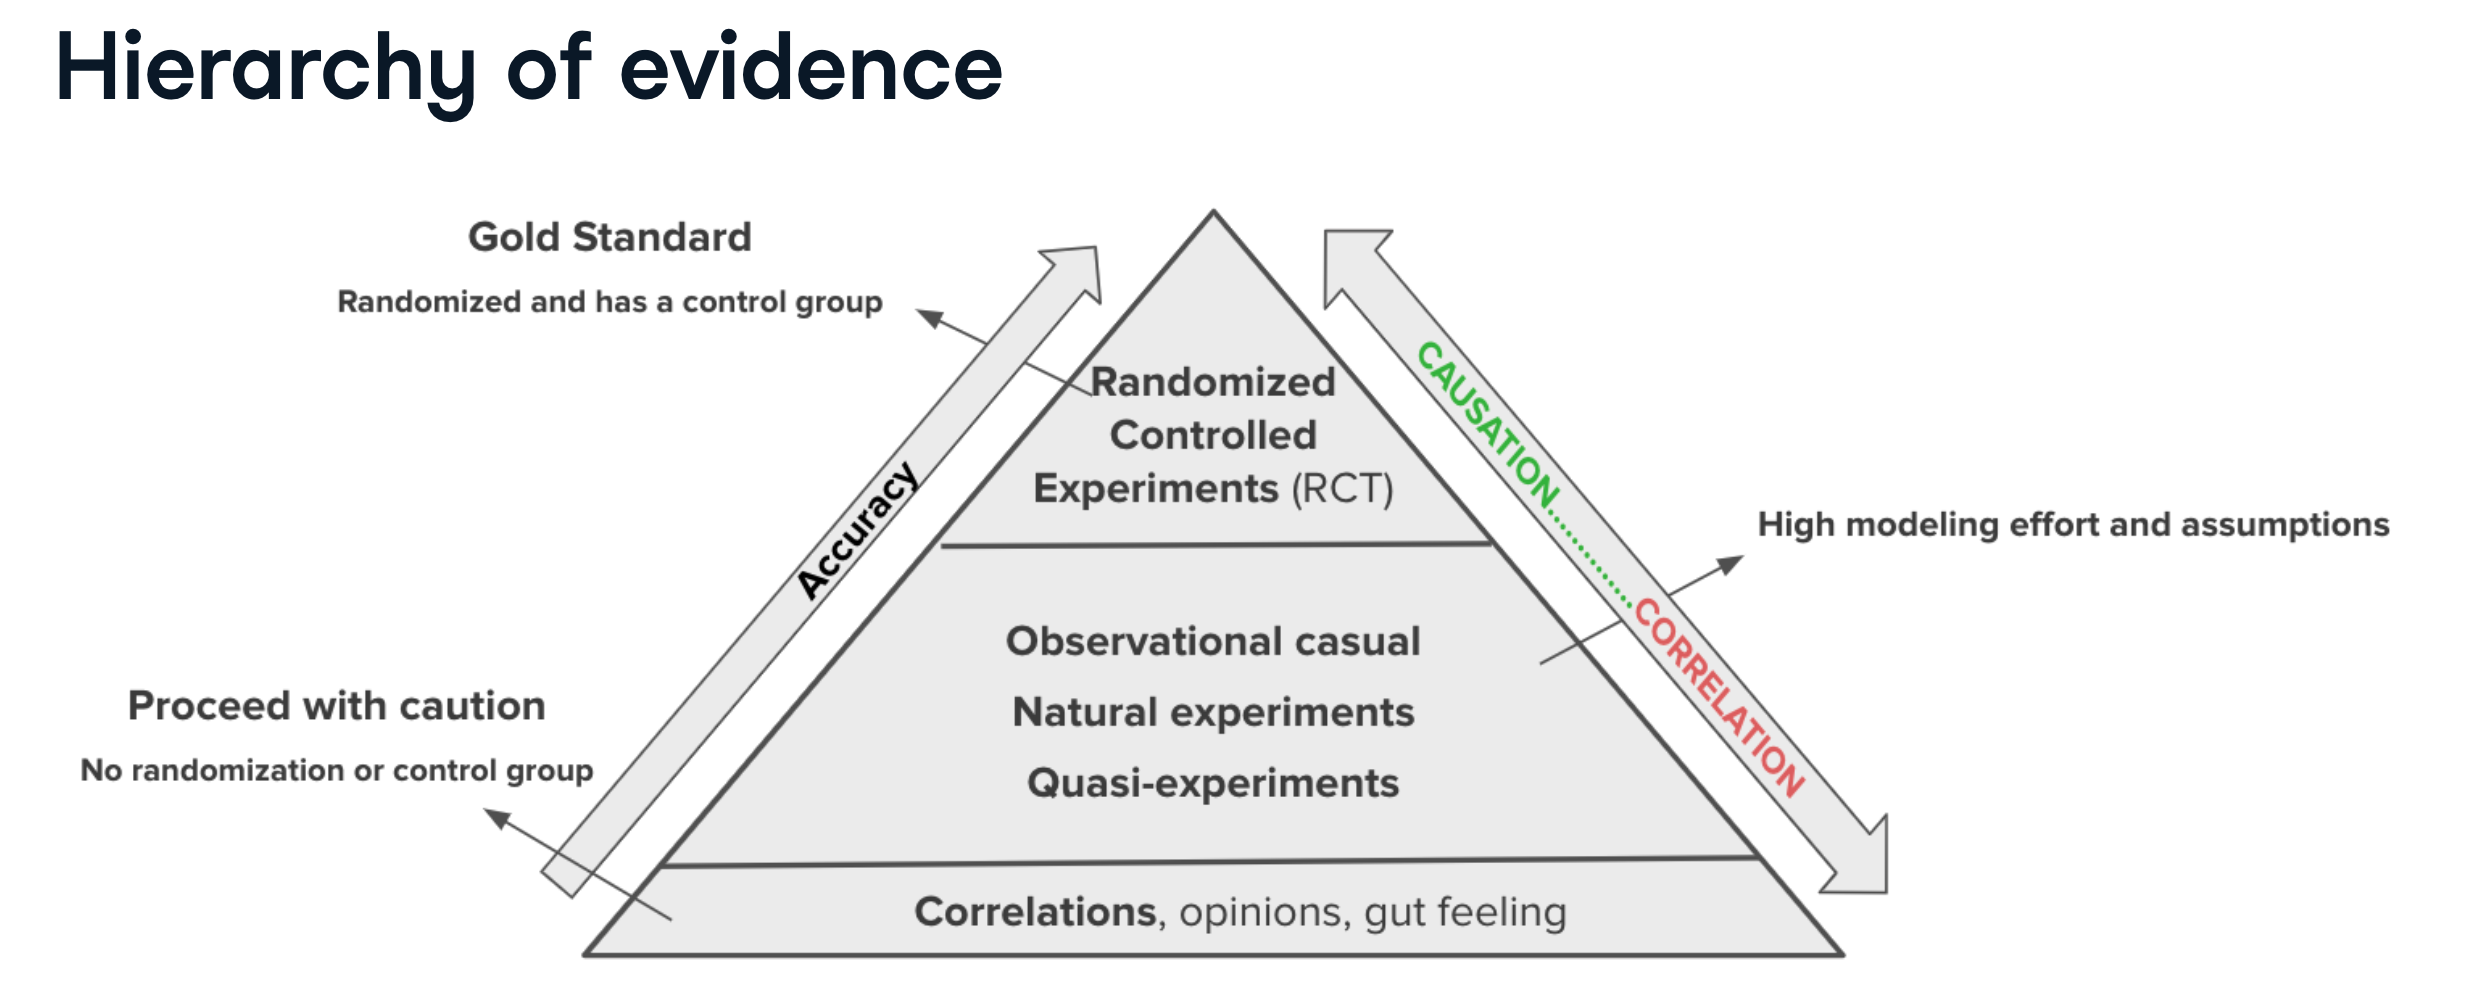

Even if the correlation between 2 variables is very high, it could be whats called **spurious correlation** that doesnt imply causation, but hides a 3rd element who's the real cause of the observation.

Correlation is still very useful, mainly when experiments are not an option.

## Pearson's correlation coefficient

Score that measures the strength of a linear relationship between two variables
- r>0: positive correlation
- r=0: neutral correlation
- r<0: negative correlation

$$
r = \frac{\sum (X_i - \overline{X})(Y_i - \overline{Y})}{\sqrt{\sum (X_i - \overline{X})^2 \sum (Y_i - \overline{Y})^2}}
$$

Where:
- $X_i$ and $Y_i$ are the individual data points for the variables $X$ and $Y$.
- $\overline{X}$ and $\overline{Y}$ are the mean values of $X$ and $Y$, respectively.

It asumes normality and linearity of the data.


In [ ]:
sns.pairplot(sample_df, hue='browser')

In [ ]:
sample_df[['order_value', 'time_on_page']].corr()

In [ ]:
sns.heatmap(sample_df[['order_value', 'time_on_page']].corr(), annot=True)

# Metrics design and estimation

## Primary Metrics (goal/north-star)

These metrics are the ones that best describes the success of the business or mission

Examples:
- Signup rates
- Daily active users
- Average sales per user
- Average listening time per user

## Granular metrics 

These metrics go deeper and best explain users' behaviour and are more sensitive and actionable

## Instrumentation/guardail metrics 

# Quantitative categorization of metrics

- Means/Percentiles
- Proportions and rates
  - Signup rate
  - Page abandonment rate
- Ratio:
  - Click-through-rate
  - Revenue per session
- Metrics can be combined to form a more comprehensive success/failure criteria

# Metrics Requirements

- Stable/Robust against the unimportant differences
- Sensitive to the important changes
- Measurable within logging limitations
- Non-gameable


In [ ]:
checkout.groupby('gender')['purchased'].mean()

In [ ]:
checkout[(checkout['browser'].isin(['chrome', 'safari']))].groupby('gender')['order_value'].mean()

In [ ]:
checkout.groupby('browser')[['order_value', 'purchased']].mean()

In [ ]:
# Calculate the mean order value for each group
checkout.groupby('checkout_page')['order_value'].mean()

# Hypothesis formulations 

A **hypothesis** is:
- a statement explaining an event
- a starting point for further investigation
- an idea we want to test

A strong hypothesis:
- is testable, declarative, concise and logical
- enables systematic iteration
- is easier to generalize and confirm understanding
- results in actionable/focused recommendations

The general framing format for hypothesis: 
- Based on X, we believe that if we do Y
- Then Z will happen
- As measured by metric(s) M

Example of the **alternative hypothesis**: 
- Based on user experience research, we believe that if we update our checkout page design
- Then the percentage of purchasing customers will increase
- As measured by purchase rate

The **null hypothesis** is: the percentge of purchasing customers will not change

Lets test this hypothesis on checkout page 'A' and 'B'.

In [ ]:
checkout.head()

In [ ]:
# Lets calculate sample statistics

# Number of users on each group 
n_A = checkout[checkout['checkout_page']=='A']['purchased'].count()
n_B = checkout[checkout['checkout_page']=='B']['purchased'].count()

print(f'n_A: {n_A}')
print(f'n_B: {n_B}')

In [ ]:
# Number of users on each group 
p_A = checkout[checkout['checkout_page']=='A']['purchased'].mean()
p_B = checkout[checkout['checkout_page']=='B']['purchased'].mean()

print(f'p_A: {p_A:.3f}')
print(f'p_B: {p_B:.3f}')

The number of purchasers in **n** trials with purchasing probability **p** is Binomially distributed

In [ ]:
from scipy.stats import binom

x = np.arange(n_A*p_A - 100, n_B*p_B + 100)
binom_a = binom.pmf(x,n_A, p_A)
binom_b = binom.pmf(x,n_B, p_B)

plt.bar(x, binom_a, alpha=0.4, label='checkout A')
plt.bar(x, binom_b, alpha=0.4, label='checkout B')
plt.xlabel('Purchased')
plt.ylabel('PMF')
plt.title('PMF of checkouts Binomial distribution')
plt.show()


These distributions tell us the probabilities of, at most, a certain number of users purchasing in each group, but they don't tell us anything about the long-term purchase probability of the overall population if we were to present either checkout page to the users. To do so, we need to make inferences on the means using a normal distribution.

Recall that the **central limit theorem** states that as the sample size gets larger, the distribution of the sample means, p, will be normally distributed around the true population mean with a standard deviation equal to the standard error of the mean irrespective of the shape of the distribution of the data. We use this to approximate the true mean of the population from which the data was sampled using this formula where p and n are the mean proportion and the sample size respectively.

$$
\hat{p} \sim \text{Normal} \left( \mu = p, \, \sigma = \frac{\sqrt{p(1-p)}}{\sqrt{n}} \right)
$$

In [ ]:
np.random.seed(47)
sampled_means = []
for i in range(1000):
    sample = checkout['purchased'].sample(100, replace=True)
    sample_mean = np.mean(sample)
    sampled_means.append(sample_mean) 

sns.displot(sampled_means, kde=True)
plt.show()

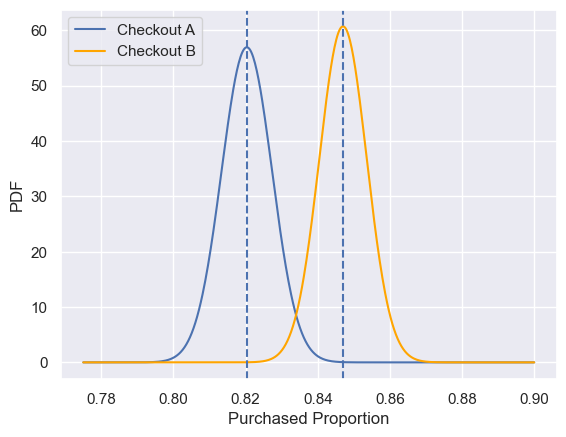

In [51]:
# Import norm from scipy library
from scipy.stats import norm

# Create x-axis range and normal distributions A and B
x = np. linspace(0.775, 0.9, 500)
norm_a = norm.pdf(x, p_A, np.sqrt(p_A*(1-p_A) / n_A))
norm_b = norm.pdf(x, p_B, np.sqrt(p_B*(1-p_B) / n_B))

# Plot normal distributions A and B
ax = sns.lineplot(x = x, y= norm_a, label='Checkout A') 
sns.lineplot(x = x, y = norm_b, color='orange', ax=ax, label= 'Checkout B')
ax.axvline(p_A, linestyle='--')
ax.axvline(p_B, linestyle='--')

plt.xlabel ('Purchased Proportion')
plt.ylabel('PDF')
plt.legend (loc="upper left")
plt.show()

Since the sample means will follow a normal distribution, we can plot them for groups A and B using scipy's norm-dot-pdf and Seaborn's lineplot using the formulas of the mean and standard error shown previously. The dashed lines represent the mean purchase rate for each group and the distance d is the mean difference between them. Since both distributions are normal, d also follows a normal distribution. This allows us to represent our original hypothesis mathematically as: 

The null hypothesis stating that the updated checkout page will result in no difference in purchase rates between the groups, and an alternative hypothesis stating that the updated design will result in a non-zero difference in purchase rate.

$$
d = p_B - p_A
$$

$$
H_0: d = p_B - p_A = 0
$$

$$
H_1: d = p_B - p_A \neq 0
$$

# Setting up testing parameters 

Following up on our checkout page AB test example, recall that the difference between mean purchase rates d follows a normal distribution. Therefore, the null hypothesis which assumes no difference in purchase rates between the groups will be centered around zero, and the alternative hypothesis will be centered around the observed difference between the mean purchase rates with the same standard error of the difference. Our goal is to test whether this difference is unlikely to occur under the Null hypothesis. If it is unlikely, we reject the Null hypothesis and claim that the difference is statistically significant.

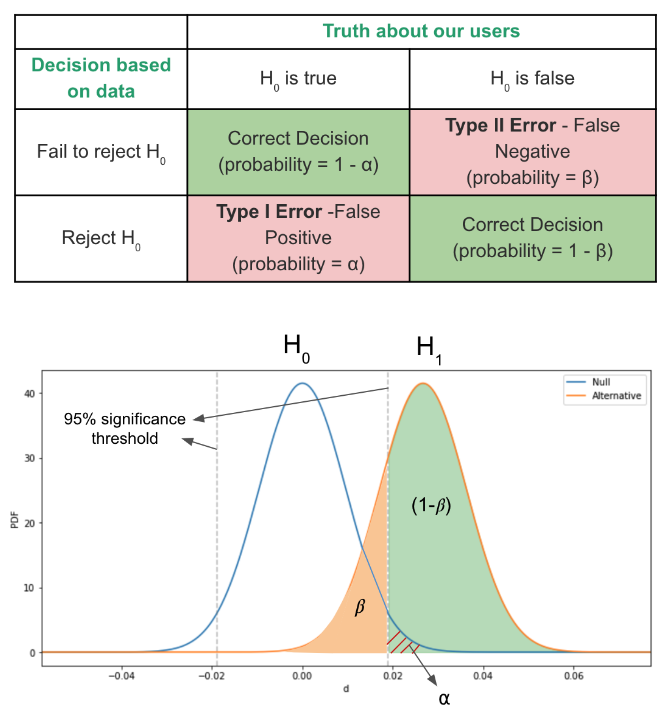

## Parameters:

### Power($1-\beta$)

$\beta$ is the type 2 error (False Negative)

Power is commonly set at 80% 

### Minimum Detectable effect (MDE)

Smallest difference we want to capture 

### Significance level $\alpha$ 

$\alpha$ is the type 1 error (False Positive)

Commonly set at 5% 

### P-Value

Probability of obtaining the observed result or more extreme, assuming the Null hypothesis is true.

- If p-value < $\alpha$ then reject the Null Hypothesis
- If p-value > $\alpha$ then fail to reject the Null Hypothesis

Assuming the Null hypothesis is true, the p-valye represents the probability of obtaining the observed results or something more extreme.

# Power Analysis

